# COMS 4995 HW4
#### Jianfeng Zhuang: JZ3872
#### Huazhang Liu: HL3338

### Task 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import randint
import random

In [2]:
from category_encoders import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.woe import WOEEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost.sklearn import XGBRegressor

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression

#### Raw Data

In [4]:
wine = pd.read_csv("winemag-data-130k-v2.csv")
wine = wine.drop("Unnamed: 0", axis = 1)
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [6]:
wine_US = wine[wine['country'] == "US"]
wine_US = wine_US.drop('country', axis = 1)
wine_US.index = np.arange(0, wine_US.shape[0])
wine_US

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
1,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
2,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
3,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
4,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
...,...,...,...,...,...,...,...,...,...,...,...,...
54499,Hailing from one of the more popular vineyards...,Jurassic Park Vineyard Old Vines,90,20.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,@mattkettmann,Birichino 2013 Jurassic Park Vineyard Old Vine...,Chenin Blanc,Birichino
54500,There's no bones about the use of oak in this ...,Barrel Fermented,90,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Flora Springs 2013 Barrel Fermented Chardonnay...,Chardonnay,Flora Springs
54501,This opens with herbaceous dollops of thyme an...,Blocks 7 & 22,90,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Hendry 2012 Blocks 7 & 22 Zinfandel (Napa Valley),Zinfandel,Hendry
54502,This Zinfandel from the eastern section of Nap...,NaN,90,22.0,California,Chiles Valley,Napa,Virginie Boone,@vboone,Houdini 2011 Zinfandel (Chiles Valley),Zinfandel,Houdini


From the above, we know that the target column is "points'. 

In [7]:
wine_US['designation'].unique().shape

(14184,)

In [8]:
wine_US[wine_US['designation'] == "Reserve"]

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
91,"There is an odd, piercing edge to the aromas, ...",Reserve,85,28.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Silvan Ridge 2006 Reserve Pinot Noir (Willamet...,Pinot Noir,Silvan Ridge
98,"Tasty, with pie-filling cherries, blackberries...",Reserve,85,25.0,California,Sonoma Mountain,Sonoma,NaN,NaN,Work 2004 Reserve Merlot (Sonoma Mountain),Merlot,Work
125,"With a fruity-sugary finish, this Zin will app...",Reserve,86,34.0,California,Mendocino,NaN,NaN,NaN,Brutocao 2006 Reserve Zinfandel (Mendocino),Zinfandel,Brutocao
161,"Fine acidity and a bracing minerality, like a ...",Reserve,92,40.0,California,Carneros,Napa-Sonoma,NaN,NaN,Robert Mondavi 2011 Reserve Chardonnay (Carneros),Chardonnay,Robert Mondavi
226,"This is a lovely wine, classically rendered in...",Reserve,93,70.0,California,Howell Mountain,Napa,Virginie Boone,@vboone,W.H. Smith 2012 Reserve Cabernet Sauvignon (Ho...,Cabernet Sauvignon,W.H. Smith
...,...,...,...,...,...,...,...,...,...,...,...,...
54412,"This robust wine is made from 62% Merlot, 37% ...",Reserve,90,140.0,California,Sonoma County-Napa County,Napa-Sonoma,Virginie Boone,@vboone,Pride Mountain 2013 Reserve Claret (Sonoma Cou...,Claret,Pride Mountain
54420,"Blackberry juice mixes with graphite, cedar an...",Reserve,90,50.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,@mattkettmann,Brander 2014 Reserve Cabernet Sauvignon (Santa...,Cabernet Sauvignon,Brander
54462,Dusty tannins make for a soft texture in this ...,Reserve,90,44.0,California,Carneros,Napa-Sonoma,Virginie Boone,@vboone,Ca' Momi 2013 Reserve Merlot (Carneros),Merlot,Ca' Momi
54475,"This wine is mostly Cabernet Sauvignon (78%), ...",Reserve,90,60.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Matthews 2012 Reserve Red (Columbia Valley (WA)),Bordeaux-style Red Blend,Matthews


In [9]:
wine_US['region_1'].unique().shape

(265,)

However, since the information contained in this column is complicated, including the city names, county names, even the names of the states, it should be used as text. 

In [10]:
wine_US['region_2'].unique().shape

(18,)

In [11]:
sum(pd.isna(wine_US['region_2']))/len(wine_US)

0.07326067811536768

In [12]:
sum(pd.isna(wine_US['region_2']))

3993

In [13]:
wine_US[wine_US['region_2'] == "Napa"]

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
3,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
20,This shows jelly-like flavors of orange and pe...,Estate Bottled,85,30.0,California,Napa Valley,Napa,NaN,NaN,RustRidge 2010 Estate Bottled Chardonnay (Napa...,Chardonnay,RustRidge
23,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Okapi 2013 Estate Cabernet Sauvignon (Napa Val...,Cabernet Sauvignon,Okapi
30,"Juicy plum, raspberry and pencil lead lead the...",Bella Vetta Vineyard,86,75.0,California,Howell Mountain,Napa,Virginie Boone,@vboone,Hindsight 2013 Bella Vetta Vineyard Cabernet S...,Cabernet Sauvignon,Hindsight
31,This is the producer's first release of this w...,Estate Grown,86,55.0,California,Calistoga,Napa,Virginie Boone,@vboone,Hindsight 2012 Estate Grown Petite Sirah (Cali...,Petite Sirah,Hindsight
...,...,...,...,...,...,...,...,...,...,...,...,...
54483,"Aged entirely in stainless steel, this combine...",Proprietary,91,30.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Paraduxx 2015 Proprietary White (Napa Valley),White Blend,Paraduxx
54485,Pencil shaving and graphite notes lend a class...,NaN,91,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Conn Creek 2013 Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,Conn Creek
54500,There's no bones about the use of oak in this ...,Barrel Fermented,90,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Flora Springs 2013 Barrel Fermented Chardonnay...,Chardonnay,Flora Springs
54501,This opens with herbaceous dollops of thyme an...,Blocks 7 & 22,90,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Hendry 2012 Blocks 7 & 22 Zinfandel (Napa Valley),Zinfandel,Hendry


Since there are are total of 14184 unique values of designations, and there are 1485 observations with designation "Reserve", this column is considered as a text column.  

In [14]:
wine_US['taster_name'].unique().shape

(16,)

In [15]:
wine_US['title'].unique().shape

(50229,)

In [16]:
wine_US['variety'].unique().shape

(257,)

In [17]:
wine_US['winery'].unique().shape

(5375,)

In [18]:
wine_US['points'] = wine_US['points'].astype('float64')

Since the column "Winery" consists of 5375 rows, and mostly composited of names, it should be used as a categorical variable through target encoding. 

In [19]:
wine_US_1 = wine_US.copy()

In [20]:
wine_US_1.head()

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,"Tart and snappy, the flavors of lime flesh and...",NaN,87.0,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
1,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87.0,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
2,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87.0,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
3,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87.0,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
4,"Slightly reduced, this wine offers a chalky, t...",NaN,87.0,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


In [21]:
wine_US_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54504 entries, 0 to 54503
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   description            54504 non-null  object 
 1   designation            36908 non-null  object 
 2   points                 54504 non-null  float64
 3   price                  54265 non-null  float64
 4   province               54504 non-null  object 
 5   region_1               54226 non-null  object 
 6   region_2               50511 non-null  object 
 7   taster_name            37730 non-null  object 
 8   taster_twitter_handle  34741 non-null  object 
 9   title                  54504 non-null  object 
 10  variety                54504 non-null  object 
 11  winery                 54504 non-null  object 
dtypes: float64(2), object(10)
memory usage: 5.4+ MB


In [22]:
wine_US_1['points'] = wine_US_1['points'].astype('float64')

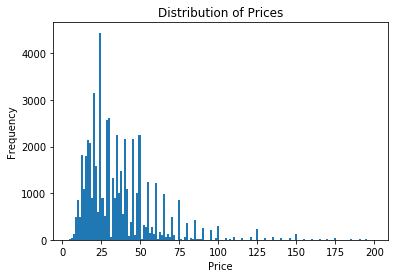

In [23]:
plt.hist(wine_US_1['price'][(wine_US_1['price'] > 0) & (wine_US_1['price'] <200)], bins = 'auto')
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [24]:
# The list of bottle that has price over 250.
wine_US_1['price'][wine_US_1['price']> 250]

723       300.0
1355      260.0
6301      500.0
10445     625.0
11101     260.0
11370     265.0
16152     625.0
17341     275.0
18478     325.0
18976     275.0
20959     275.0
21029     275.0
21030     450.0
21037     275.0
21570     750.0
22755     260.0
24197     275.0
28892     300.0
31065     325.0
31392     300.0
31787     350.0
34021     300.0
34033     260.0
34434     275.0
34870     625.0
41033     400.0
41363     325.0
43018     450.0
45913     325.0
45936     275.0
48524     300.0
49399     450.0
49403     450.0
49404     450.0
49407     450.0
50385    2013.0
51045     290.0
51054     335.0
52085     500.0
52086     290.0
54106     450.0
Name: price, dtype: float64

In [25]:
wine_US[wine_US['price'] == 625]

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
10445,"As imposing as the athlete himself, this is an...",Family Reserve,94.0,625.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Yao Ming 2011 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming
16152,We can debate the pricing on Yao Ming's new re...,Family Reserve,98.0,625.0,California,Napa Valley,Napa,NaN,NaN,Yao Ming 2010 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming
34870,The former basketball star's initial release i...,Family Reserve,97.0,625.0,California,Napa Valley,Napa,NaN,NaN,Yao Ming 2009 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming


In [26]:
wine_US[wine_US['price'] == 500]

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
6301,This is a hugely structured and concentrated w...,Double Plus Estate Grown,93.0,500.0,California,Rutherford,Napa,Virginie Boone,@vboone,Hewitt 2013 Double Plus Estate Grown Cabernet ...,Cabernet Sauvignon,Hewitt
52085,"Here's a big, flashy, cult-style wine if ever ...",NaN,94.0,500.0,California,Napa Valley,Napa,NaN,NaN,Harlan Estate 2006 Red (Napa Valley),Bordeaux-style Red Blend,Harlan Estate


In [27]:
wine_US[wine_US['price'] == 750]

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
21570,"This is a powerful bottling, as is expected by...",Intrepid,92.0,750.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Law 2013 Intrepid Syrah (Paso Robles),Syrah,Law


In [28]:
wine_US[wine_US['price'] == 2013]

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
50385,The nose on this single-vineyard wine from a s...,Roger Rose Vineyard,91.0,2013.0,California,Arroyo Seco,Central Coast,Matt Kettmann,@mattkettmann,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,Chardonnay,Blair


We did some research and found that the wine with price 2013 and 750 are typo, so we decide to delete these two rows.

In [29]:
wine_US_1 = wine_US_1[(wine_US_1['price']!= 2013) & (wine_US_1['price'] != 750)]

In [30]:
wine_US_1[pd.isna(wine_US_1['region_2'])]['province'].value_counts()

California           2128
Virginia              777
Oregon                306
Idaho                 192
Michigan              114
America                95
Texas                  94
Colorado               68
New Mexico             45
Arizona                41
Missouri               33
North Carolina         23
Pennsylvania           18
Ohio                   12
New Jersey              8
Massachusetts           7
Washington-Oregon       7
Illinois                6
Nevada                  4
Iowa                    4
Vermont                 3
Connecticut             3
Washington              2
Hawaii                  1
Kentucky                1
Rhode Island            1
Name: province, dtype: int64

In [31]:
wine_US_1[wine_US_1['province'] == 'California']['region_2'].value_counts()

Central Coast       11063
Sonoma               9028
Napa                 6814
California Other     2663
Sierra Foothills     1462
Napa-Sonoma          1169
Central Valley       1062
North Coast           584
South Coast           272
Name: region_2, dtype: int64

In [32]:
wine_US_1[pd.isna(wine_US_1['region_2']) == False]['province'].value_counts()

California    34117
Washington     8637
Oregon         5067
New York       2688
Name: province, dtype: int64

Since there are too many missing values in this columns, we decide to delete the rows with missing in this feature. 

In [33]:
sum(pd.isna(wine_US_1['taster_name']))

16774

In [34]:
wine_US_1 = wine_US_1[pd.isna(wine_US_1['taster_name']) == False]
wine_US_1 = wine_US_1[pd.isna(wine_US_1['description']) == False]
wine_US_1 = wine_US_1[pd.isna(wine_US_1['designation']) == False]
wine_US_1 = wine_US_1[pd.isna(wine_US_1['region_1']) == False]
wine_US_1 = wine_US_1[pd.isna(wine_US_1['region_2']) == False]
wine_US_1 = wine_US_1[pd.isna(wine_US_1['title']) == False]

In [35]:
# Subsample
sample_wine_US_1 = wine_US_1.sample(10000, random_state=1)
sample_wine_US_1.to_csv('sample_wine_US_1.csv')

In [36]:
sample_wine_US_1

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
21701,This is essentially a southern Oregon blend of...,Red,84.0,19.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Purple Hands 2009 Red Red (Oregon),Red Blend,Purple Hands
23071,Bright boysenberry fruit is blended with aroma...,Connell Vineyard,88.0,20.0,California,Bennett Valley,Sonoma,Matt Kettmann,@mattkettmann,Sandler 2015 Connell Vineyard Syrah (Bennett V...,Syrah,Sandler
16700,A nose of baked apple and saline minerality in...,Bien Nacido Vineyard,92.0,45.0,California,Santa Maria Valley,Central Coast,Matt Kettmann,@mattkettmann,Testarossa 2012 Bien Nacido Vineyard Chardonna...,Chardonnay,Testarossa
46169,"Dense in tannin and yet bristling in acidity, ...",Placida,90.0,45.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Neyers 2015 Placida Pinot Noir (Russian River ...,Pinot Noir,Neyers
2217,From a p of Sonoma Mountain exposed to the Pet...,Silver Pines Vineyard,91.0,44.0,California,Sonoma Mountain,Sonoma,Virginie Boone,@vboone,Bailiwick 2013 Silver Pines Vineyard Pinot Noi...,Pinot Noir,Bailiwick
...,...,...,...,...,...,...,...,...,...,...,...,...
16688,"This lush, toasty, vividly fruity wine can't m...",Estate,91.0,30.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Willamette Valley Vineyards 2015 Estate Chardo...,Chardonnay,Willamette Valley Vineyards
42024,This wine is a blend of equal parts Seven Hill...,Estate Grown,91.0,37.0,Washington,Walla Walla Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,L'Ecole No. 41 2013 Estate Grown Merlot (Walla...,Merlot,L'Ecole No. 41
27036,This rich and strongly aromatic bottling shows...,Kali Hart,88.0,23.0,California,Monterey,Central Coast,Matt Kettmann,@mattkettmann,Talbott 2015 Kali Hart Chardonnay (Monterey),Chardonnay,Talbott
10723,The Cabernet Franc matches well with the Merlo...,Two Vines,87.0,8.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Columbia Crest 2010 Two Vines Merlot-Cabernet ...,Merlot-Cabernet,Columbia Crest


In [37]:
X = sample_wine_US_1.drop('points', axis = 1)
y = sample_wine_US_1['points']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [39]:
#X_train.to_csv("X_train.csv")
#X_test.to_csv("X_test.csv")
#y_train.to_csv("y_train.csv")
#y_test.to_csv("y_test.csv")

In [40]:
X_train = pd.read_csv("X_train.csv", index_col='Unnamed: 0')
X_test = pd.read_csv("X_test.csv", index_col='Unnamed: 0')
y_train = pd.read_csv("y_train.csv", index_col='Unnamed: 0')
y_test = pd.read_csv('y_test.csv', index_col='Unnamed: 0')

In [41]:
X_train = X_train.drop(['description', 'designation', 'region_1', 'region_2', 
                        'taster_twitter_handle', 'title'], axis = 1)
X_test = X_test.drop(['description', 'designation', 'region_1', 'region_2', 
                      'taster_twitter_handle', 'title'], axis = 1)

In [42]:
numerical = X_train.dtypes == 'float64'
one_hot = X_train.dtypes == 'object'
one_hot.variety = False
one_hot.winery = False
target = X_train.dtypes == 'object'
target.province = False
target.taster_name = False

In [43]:
preprocess_2 = make_column_transformer((make_pipeline(SimpleImputer(strategy="median"), 
                                                      StandardScaler()), numerical),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                                      OneHotEncoder(handle_unknown="ignore")), one_hot),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                                      TargetEncoder()), target))

In [44]:
Ridge_model = make_pipeline(preprocess_2, Ridge())
Ridge_score = cross_val_score(Ridge_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(Ridge_score))

0.3540609629395168


In [45]:
X_train = pd.read_csv("X_train.csv", index_col='Unnamed: 0')
X_test = pd.read_csv("X_test.csv", index_col='Unnamed: 0')
X_train = X_train.drop(['price', 'province', 'taster_name', 'taster_twitter_handle', 
                        'variety', 'winery'], axis = 1)
X_test = X_test.drop(['price', 'province', 'taster_name', 
                      'taster_twitter_handle', 'variety', 'winery'], axis = 1)

In [46]:
X_train

,description,designation,region_1,region_2,title
13892,Argyle's Reserve shows less oak than the Nutho...,Reserve,Willamette Valley,Willamette Valley,Argyle 1999 Reserve Chardonnay (Willamette Val...
12884,"This is an irresistibly tasty wine, bursting w...",Côte Est,Willamette Valley,Willamette Valley,Le Cadeau 2014 Côte Est Pinot Noir (Willamette...
12031,"An oil-like shade of yellow in the glass, this...",Estate Bottled,Santa Cruz Mountains,Central Coast,Mount Eden Vineyards 2014 Estate Bottled Chard...
1285,Ripe raspberry jam scents gain intrigue thanks...,Knox Alexander,Santa Maria Valley,Central Coast,Au Bon Climat 2011 Knox Alexander Pinot Noir (...
22821,"Aromas of raspberry, plum, freshly ground blac...",Estate Grown,Walla Walla Valley (WA),Columbia Valley,Spring Valley Vineyard 2014 Estate Grown Malbe...
...,...,...,...,...,...
12783,This has oodles of ripe boysenberry and huckle...,Estate Grown,Lodi,Central Valley,Fields Family 2012 Estate Grown Syrah (Lodi)
16256,It might seem odd to plant Syrah in the heart ...,Calkins Lane Vineyard,Chehalem Mountains,Willamette Valley,Adelsheim 2009 Calkins Lane Vineyard Syrah (Ch...
12272,"This is a lovely vineyard-designate, floral an...",Scopus Vineyard Reserve,Sonoma County,Sonoma,City Winery of New York 2014 Scopus Vineyard R...
20362,"Mocha, baked plum and black pepper play equal ...",Beckstoffer To Kalon Vineyard,Oakville,Napa,Macauley 2013 Beckstoffer To Kalon Vineyard Ca...


In [47]:
preprocess_3 = make_column_transformer((CountVectorizer(), 'description'),
                                       (CountVectorizer(), 'designation'),
                                       (CountVectorizer(), 'region_1'),
                                       (CountVectorizer(), 'region_2'),
                                       (CountVectorizer(), 'title'))

In [48]:
Ridge_model = make_pipeline(preprocess_3, Ridge())
Ridge_score = cross_val_score(Ridge_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(Ridge_score))

0.576227128640272


In [49]:
preprocess_4 = make_column_transformer((CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b"), 'description'),
                                       (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b"), 'designation'),
                                       (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b"), 'region_1'),
                                       (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b"), 'region_2'),
                                       (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b"), 'title'))

In [50]:
Ridge_model = make_pipeline(preprocess_4, Ridge())
Ridge_score = cross_val_score(Ridge_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(Ridge_score))

0.6434498786000513


In [51]:
preprocess_5 = make_column_transformer((CountVectorizer(token_pattern=r"\b\w[\w’]+\b"), 'description'),
                                       (CountVectorizer(token_pattern=r"\b\w[\w’]+\b"), 'designation'),
                                       (CountVectorizer(token_pattern=r"\b\w[\w’]+\b"), 'region_1'),
                                       (CountVectorizer(token_pattern=r"\b\w[\w’]+\b"), 'region_2'),
                                       (CountVectorizer(token_pattern=r"\b\w[\w’]+\b"), 'title'))

#### Tuning ngram_range

In [52]:
param_grid_1 = {"columntransformer__countvectorizer-1__ngram_range": [(1, 1), (1, 3), (1, 5),
                                                                    (1, 7), (2, 3), (2, 5)],
                "columntransformer__countvectorizer-2__ngram_range": [(1, 3)],
                "columntransformer__countvectorizer-3__ngram_range": [(1, 3)],
                "columntransformer__countvectorizer-4__ngram_range": [(1, 3)],
                "columntransformer__countvectorizer-5__ngram_range": [(1, 1),(1, 3), (1, 5)],
               }
grid_1 = GridSearchCV(make_pipeline(preprocess_5, Normalizer(), Ridge()),
                    param_grid=param_grid_1, cv=5)

In [53]:
grid_1.fit(X_train, np.ravel(y_train))
print('Best Params for grid_1:',grid_1.best_params_)
print('Best Score for grid_1:',grid_1.best_score_ )

Best Params for grid_1: {'columntransformer__countvectorizer-1__ngram_range': (1, 1), 'columntransformer__countvectorizer-2__ngram_range': (1, 3), 'columntransformer__countvectorizer-3__ngram_range': (1, 3), 'columntransformer__countvectorizer-4__ngram_range': (1, 3), 'columntransformer__countvectorizer-5__ngram_range': (1, 1)}
Best Score for grid_1: 0.62119281572774


#### Compare using Normalizer or TfidTransformer

In [54]:
Ridge_model = make_pipeline(preprocess_4, Normalizer(), Ridge())
Ridge_score = cross_val_score(Ridge_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(Ridge_score))

0.5783949532494155


In [55]:
Ridge_model = make_pipeline(preprocess_4, TfidfTransformer(), Ridge())
Ridge_score = cross_val_score(Ridge_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(Ridge_score))

0.5792258788352609


Since the score is even lower, we should not add in Normalizer or TfidTransformer. 

#### Tuning min_df

In [56]:
param_grid_mindf = {"columntransformer__countvectorizer-1__min_df": [1, 2, 3],
                    "columntransformer__countvectorizer-2__min_df": [1, 2],
                    "columntransformer__countvectorizer-3__min_df": [1, 2],
                    "columntransformer__countvectorizer-4__min_df": [1, 2],
                    "columntransformer__countvectorizer-5__min_df": [1, 2, 3],
                   }
grid_mindf = GridSearchCV(make_pipeline(preprocess_4, Ridge()),
                    param_grid=param_grid_mindf, cv=5)
grid_mindf.fit(X_train, np.ravel(y_train))
print('Best Params for grid_mindf:',grid_mindf.best_params_)
print('Best Score for grid_mindf:',grid_mindf.best_score_ )

Best Params for grid_mindf: {'columntransformer__countvectorizer-1__min_df': 1, 'columntransformer__countvectorizer-2__min_df': 1, 'columntransformer__countvectorizer-3__min_df': 1, 'columntransformer__countvectorizer-4__min_df': 1, 'columntransformer__countvectorizer-5__min_df': 1}
Best Score for grid_mindf: 0.6434498786000513


After tuning, we know that the best parameter for each one is 1. 

#### Tuning alpha of Ridge model

In [57]:
ridge_list = [i for i in np.arange(0.00015,0.00025,0.00001)]

In [58]:
param_grid_ridge = {"ridge__alpha": ridge_list,
                    "columntransformer__countvectorizer-1__min_df": [1],
                    "columntransformer__countvectorizer-2__min_df": [1],
                    "columntransformer__countvectorizer-3__min_df": [1],
                    "columntransformer__countvectorizer-4__min_df": [1],
                    "columntransformer__countvectorizer-5__min_df": [1],
                   }
grid_ridge = GridSearchCV(make_pipeline(preprocess_4, Ridge()),
                    param_grid=param_grid_ridge, cv=5)
grid_ridge.fit(X_train, np.ravel(y_train))
print('Best Params for grid_ridge:',grid_ridge.best_params_)
print('Best Score for grid_ridge:',grid_ridge.best_score_ )

Best Params for grid_ridge: {'columntransformer__countvectorizer-1__min_df': 1, 'columntransformer__countvectorizer-2__min_df': 1, 'columntransformer__countvectorizer-3__min_df': 1, 'columntransformer__countvectorizer-4__min_df': 1, 'columntransformer__countvectorizer-5__min_df': 1, 'ridge__alpha': 0.00017999999999999998}
Best Score for grid_ridge: 0.6434398543166544


The best alpha for ridge model is 0.00018.

In [59]:
print(grid_ridge.score(X_test, np.ravel(y_test)))

0.6556796972441112


### Task 1.3

In [60]:
sample_wine_US_1

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
21701,This is essentially a southern Oregon blend of...,Red,84.0,19.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Purple Hands 2009 Red Red (Oregon),Red Blend,Purple Hands
23071,Bright boysenberry fruit is blended with aroma...,Connell Vineyard,88.0,20.0,California,Bennett Valley,Sonoma,Matt Kettmann,@mattkettmann,Sandler 2015 Connell Vineyard Syrah (Bennett V...,Syrah,Sandler
16700,A nose of baked apple and saline minerality in...,Bien Nacido Vineyard,92.0,45.0,California,Santa Maria Valley,Central Coast,Matt Kettmann,@mattkettmann,Testarossa 2012 Bien Nacido Vineyard Chardonna...,Chardonnay,Testarossa
46169,"Dense in tannin and yet bristling in acidity, ...",Placida,90.0,45.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Neyers 2015 Placida Pinot Noir (Russian River ...,Pinot Noir,Neyers
2217,From a p of Sonoma Mountain exposed to the Pet...,Silver Pines Vineyard,91.0,44.0,California,Sonoma Mountain,Sonoma,Virginie Boone,@vboone,Bailiwick 2013 Silver Pines Vineyard Pinot Noi...,Pinot Noir,Bailiwick
...,...,...,...,...,...,...,...,...,...,...,...,...
16688,"This lush, toasty, vividly fruity wine can't m...",Estate,91.0,30.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Willamette Valley Vineyards 2015 Estate Chardo...,Chardonnay,Willamette Valley Vineyards
42024,This wine is a blend of equal parts Seven Hill...,Estate Grown,91.0,37.0,Washington,Walla Walla Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,L'Ecole No. 41 2013 Estate Grown Merlot (Walla...,Merlot,L'Ecole No. 41
27036,This rich and strongly aromatic bottling shows...,Kali Hart,88.0,23.0,California,Monterey,Central Coast,Matt Kettmann,@mattkettmann,Talbott 2015 Kali Hart Chardonnay (Monterey),Chardonnay,Talbott
10723,The Cabernet Franc matches well with the Merlo...,Two Vines,87.0,8.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Columbia Crest 2010 Two Vines Merlot-Cabernet ...,Merlot-Cabernet,Columbia Crest


In [61]:
X_train = pd.read_csv("X_train.csv", index_col='Unnamed: 0')
X_test = pd.read_csv("X_test.csv", index_col='Unnamed: 0')
y_train = pd.read_csv("y_train.csv", index_col='Unnamed: 0')
y_test = pd.read_csv('y_test.csv', index_col='Unnamed: 0')

In [62]:
X_train

,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
13892,Argyle's Reserve shows less oak than the Nutho...,Reserve,20.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Argyle 1999 Reserve Chardonnay (Willamette Val...,Chardonnay,Argyle
12884,"This is an irresistibly tasty wine, bursting w...",Côte Est,50.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Le Cadeau 2014 Côte Est Pinot Noir (Willamette...,Pinot Noir,Le Cadeau
12031,"An oil-like shade of yellow in the glass, this...",Estate Bottled,64.0,California,Santa Cruz Mountains,Central Coast,Matt Kettmann,@mattkettmann,Mount Eden Vineyards 2014 Estate Bottled Chard...,Chardonnay,Mount Eden Vineyards
1285,Ripe raspberry jam scents gain intrigue thanks...,Knox Alexander,45.0,California,Santa Maria Valley,Central Coast,Matt Kettmann,@mattkettmann,Au Bon Climat 2011 Knox Alexander Pinot Noir (...,Pinot Noir,Au Bon Climat
22821,"Aromas of raspberry, plum, freshly ground blac...",Estate Grown,50.0,Washington,Walla Walla Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Spring Valley Vineyard 2014 Estate Grown Malbe...,Malbec,Spring Valley Vineyard
...,...,...,...,...,...,...,...,...,...,...,...
12783,This has oodles of ripe boysenberry and huckle...,Estate Grown,24.0,California,Lodi,Central Valley,Jim Gordon,@gordone_cellars,Fields Family 2012 Estate Grown Syrah (Lodi),Syrah,Fields Family
16256,It might seem odd to plant Syrah in the heart ...,Calkins Lane Vineyard,45.0,Oregon,Chehalem Mountains,Willamette Valley,Paul Gregutt,@paulgwine,Adelsheim 2009 Calkins Lane Vineyard Syrah (Ch...,Syrah,Adelsheim
12272,"This is a lovely vineyard-designate, floral an...",Scopus Vineyard Reserve,28.0,California,Sonoma County,Sonoma,Virginie Boone,@vboone,City Winery of New York 2014 Scopus Vineyard R...,Chardonnay,City Winery of New York
20362,"Mocha, baked plum and black pepper play equal ...",Beckstoffer To Kalon Vineyard,175.0,California,Oakville,Napa,Virginie Boone,@vboone,Macauley 2013 Beckstoffer To Kalon Vineyard Ca...,Cabernet Sauvignon,Macauley


In [63]:
numerical = X.dtypes == 'float64'
one_hot = X.dtypes == 'object'
one_hot.variety = False
one_hot.winery = False
one_hot.description = False
one_hot.designation = False
one_hot.region_1 = False
one_hot.region_2 = False
one_hot.title = False
target = X.dtypes == 'object'
target.province = False
target.taster_name = False
target.description = False
target.designation = False
target.region_1 = False
target.region_2 = False
target.title = False

In [64]:
preprocess_final = make_column_transformer((make_pipeline(SimpleImputer(strategy="median"), 
                                                          StandardScaler()), numerical),
                                           (make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                                          OneHotEncoder(handle_unknown="ignore")), one_hot),
                                           (make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                                          TargetEncoder()), target),
                                           (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b", 
                                                            min_df = 1), 'description'),
                                           (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b", 
                                                            min_df = 1), 'designation'),
                                           (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b", 
                                                            min_df = 1), 'region_1'),
                                           (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b", 
                                                            min_df = 1), 'region_2'),
                                           (CountVectorizer(ngram_range=(1, 3), token_pattern=r"\b\w[\w’]+\b", 
                                                            min_df = 1), 'title'))

In [65]:
final_model = make_pipeline(preprocess_final, Ridge(alpha = 0.00018))
final_score = cross_val_score(final_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(final_score))

0.6505813989794533


After combing non-text model and text model, the score becomes lower. This is because the score for non-text model is very low, thus the total score becomes lower. 